In [2]:
import pandas as pd
import requests
import urllib.parse
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

First, I will collect all of the available sources of empirical data in Alaska. All of these sources are from the Alaska Energy Authority and can be accessed through the C2C API.

In [2]:
# with open('AEA_SITES.txt', 'w') as f:
#     aea_site_request_url = "http://0.0.0.0:3000/api/search/aea/sites/coord_search?lat=65&lon=-151&lat_threshold=20&lon_threshold=20"
#
#     aea_site_response = requests.get(aea_site_request_url)
#     for site in aea_site_response.json()["sites"]:
#         f.write(site["site_name"] + " (" + str(site["latitude"]) + "," + str(site["longitude"]) + ")\n")

Then each site will be annotated with its years of data availability

In [4]:
site_df = pd.DataFrame(columns=["site", "latitude", "longitude", "elevation", "altitude","data_availability_start", "data_availability_end", "compatible_sources"])
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
with open("AEA_SITES.txt", "r") as f:
    sites = []
    for line in f.readlines():
        site = line[:line.index(" ")]
        sites.append(site)
    aea_site_years_request_url = "http://0.0.0.0:3000/api/search/aea/wind_speed?sites={}".format(",".join(sites))
    aea_site_years_request_response = requests.get(aea_site_years_request_url).json()
    for site in aea_site_years_request_response["sites"]:
        site_info = aea_site_years_request_response["sites"][site]
        site_df.loc[len(site_df.index)] = [site, site_info["latitude"], site_info["longitude"], site_info["elevation"], site_info["altitude"], list(site_info["historic_data"]["wind_speed"].keys())[0], list(site_info["historic_data"]["wind_speed"].keys())[-1], ""]
site_df

,site,latitude,longitude,elevation,altitude,data_availability_start,data_availability_end,compatible_sources
0,Tanana,65.167,-152.100,67.0,0,1973,2002,
1,Annette-Island,55.033,-131.567,34.0,0,1973,2002,
2,Middleton-Isl-Old,59.433,-146.333,14.0,0,1973,1977,
3,Cape-Spencer,58.200,-136.633,25.0,0,1973,1989,
4,BettlesField,66.917,-151.517,96.0,0,1973,2002,
...,...,...,...,...,...,...,...,...
104,Anaktuvuk-Pass,68.133,-151.733,43.0,0,1981,2002,
105,Deering,66.083,-162.750,9.0,0,1998,2002,
106,Valdez-Weather-Station-Office,61.133,-146.350,10.0,0,1973,2002,
107,Kuparuk,70.317,-149.583,20.0,0,1981,2002,


Here I used a dictionary to set the conditions for the various data sources. This information is up-to-date as of 2022-07-15

In [5]:
source_conditions = {
    "NASA": (2001, 2021),
    "WTK": (2007,2014),
    "OPEN": (1981, 2021),
    "NWS": (2022, 2022)
}
site_df.data_availability_start = pd.to_numeric(site_df.data_availability_start)
site_df.data_availability_end = pd.to_numeric(site_df.data_availability_end)
for source in source_conditions:
    site_df.loc[(source_conditions[source][0] < site_df.data_availability_end) & (source_conditions[source][1] > site_df.data_availability_start), "compatible_sources"] += source + ","

In [6]:
site_df

,site,latitude,longitude,elevation,altitude,data_availability_start,data_availability_end,compatible_sources
0,Tanana,65.167,-152.100,67.0,0,1973,2002,"NASA,OPEN,"
1,Annette-Island,55.033,-131.567,34.0,0,1973,2002,"NASA,OPEN,"
2,Middleton-Isl-Old,59.433,-146.333,14.0,0,1973,1977,
3,Cape-Spencer,58.200,-136.633,25.0,0,1973,1989,"OPEN,"
4,BettlesField,66.917,-151.517,96.0,0,1973,2002,"NASA,OPEN,"
...,...,...,...,...,...,...,...,...
104,Anaktuvuk-Pass,68.133,-151.733,43.0,0,1981,2002,"NASA,OPEN,"
105,Deering,66.083,-162.750,9.0,0,1998,2002,"NASA,OPEN,"
106,Valdez-Weather-Station-Office,61.133,-146.350,10.0,0,1973,2002,"NASA,OPEN,"
107,Kuparuk,70.317,-149.583,20.0,0,1981,2002,"NASA,OPEN,"


As demonstrated by this dataframe, there is sadly no empirical data that can be compared between the Alaska Energy Authority Data and Wind Toolkit or NWS. Along with this, NWS cannot be compared to Wind Toolkit, therefore there is no empirical source of data that can be compared to Wind Toolkit, at least out of these sources.

First, I grabbed the available data and stored it in DataFrames for quicker access.

In [7]:
aea_average_dfs = {} # dict of dataframes full of Alaska Energy Authority data, keyed by site name
aea_request_url = "http://0.0.0.0:3000/api/search/aea/wind_speed?sites={}".format(",".join(list(site_df["site"])))
aea_json = requests.get(aea_request_url).json()
for site in aea_json["sites"]:
    temp_site_df = pd.DataFrame(columns=["year", "month", "aea_wind_speed"])
    for year in aea_json["sites"][site]["historic_data"]["wind_speed"]:
        for month in aea_json["sites"][site]["historic_data"]["wind_speed"][year]:
            temp_site_df.loc[len(temp_site_df.index)] = [year, month, aea_json["sites"][site]["historic_data"]["wind_speed"][year][month]]
    temp_site_df.year = temp_site_df.year.astype("int32")
    aea_average_dfs[site] = temp_site_df

In [8]:
aea_average_dfs["Tanana"]

,year,month,aea_wind_speed
0,1973,January,2.47
1,1973,February,3.85
2,1973,March,4.63
3,1973,April,3.57
4,1973,May,4.19
...,...,...,...
295,2002,August,2.07
296,2002,September,1.23
297,2002,October,-1.00
298,2002,November,-1.00


It's safer to spread these steps out, so even though the tool is capable of getting all of this data at once, for demonstration purposes here, I hit the two separate endpoints.

In [9]:
nasa_request_endpoint = "http://0.0.0.0:3000/api/search/nasa_power"
nasa_raw_dfs = {}
for site in site_df.iterrows():
    site = site[1]
    if "NASA" in site.compatible_sources:
        nasa_payload = {
            "Latitude": site["latitude"],
            "Longitude": site["longitude"],
            "HubHeight": site["altitude"] if site["altitude"] >= 10 else 10,
            "WindSurface": "vegtype_1",
            "start": "{}-01-01T00:00:00Z".format(site["data_availability_start"]) if site["data_availability_start"] > 2001 else "2001-01-01T00:00:00Z",
            "end": "{}-12-31T23:59:59Z".format(site["data_availability_end"])
        }
        nasa_response = requests.get(nasa_request_endpoint, params=nasa_payload).json()
        time.sleep(1)
        nasa_raw_dfs[site["site"]] = pd.DataFrame(nasa_response)

In [10]:
nasa_raw_dfs["Tanana"]

,wind_speed,wind_direction
2000-12-31T21:00:00.000Z,5.64,51.92
2000-12-31T22:00:00.000Z,5.67,51.88
2000-12-31T23:00:00.000Z,5.68,51.23
2001-01-01T00:00:00.000Z,5.50,50.68
2001-01-01T01:00:00.000Z,5.33,50.16
...,...,...
2002-12-31T16:00:00.000Z,4.60,36.60
2002-12-31T17:00:00.000Z,4.60,35.42
2002-12-31T18:00:00.000Z,4.54,32.89
2002-12-31T19:00:00.000Z,4.47,30.06


In [12]:
site_nasa_data_averages = {}
for site in nasa_raw_dfs:
    site_data = site_df.loc[site_df.site == "Tanana"]
    site_nasa_data_averages[site] = pd.DataFrame(columns=["year", "month", "nasa_speed", "nasa_direction"])
    years = (site_data["data_availability_start"].values[0] if site_data["data_availability_start"].values[0] > 2001 else 2001, site_data["data_availability_end"].values[0])
    for year in years:
        for month in range(1,13):
            next_month = str(month + 1).zfill(2)
            month = str(month).zfill(2)
            if month != 12:
                temp_series = nasa_raw_dfs["Tanana"].loc["{}-{}".format(year, month):"{}-{}".format(year, next_month)].mean()
            else:
                temp_series = nasa_raw_dfs["Tanana"].loc["{}-{}".format(year, month):"{}-{}".format(year + 1, 1)].mean()
            site_nasa_data_averages[site].loc[len(site_nasa_data_averages[site].index)] = [year, months[int(month) - 1],temp_series["wind_speed"], temp_series["wind_direction"]]
site_nasa_data_averages["Tanana"].year = site_nasa_data_averages["Tanana"].year.astype("int32")

Data cleaning is done on both data sources

In [13]:
for name, df in aea_average_dfs.items():
    aea_average_dfs[name] = df.replace(-1, np.nan)
for name, df in site_nasa_data_averages.items():
    site_nasa_data_averages[name] = df.replace(-1, np.nan)

Residual/percent error df is filled for each source

In [14]:
site_residual_dfs = {}
compatible_sites = [row[0] for row in site_df.loc[site_df.compatible_sources.str.contains("NASA")].values]
for site in compatible_sites:
    temp_df = aea_average_dfs[site].loc[(aea_average_dfs[site].year <= 2002) & (aea_average_dfs[site].year > 2000)].aea_wind_speed.reset_index().drop("index", axis=1)
    residual_df = pd.concat(objs=[temp_df, site_nasa_data_averages[site].nasa_speed], axis=1)
    residual_df["residual"] = abs(residual_df.aea_wind_speed - residual_df.nasa_speed)
    residual_df["percent_error"] = abs(residual_df.aea_wind_speed - residual_df.nasa_speed)/residual_df.aea_wind_speed
    site_residual_dfs[site] = residual_df

In [30]:
site_nasa_data_averages["Annette-Island"]

,year,month,nasa_speed,nasa_direction
0,2001,January,4.729140,92.945390
1,2001,February,4.036830,110.472217
2,2001,March,4.808132,84.445484
3,2001,April,3.877264,127.799931
4,2001,May,3.494597,158.219556
5,2001,June,3.234681,206.517431
6,2001,July,2.926586,200.893589
7,2001,August,3.323414,186.299758
8,2001,September,3.013694,130.535347
9,2001,October,3.631790,106.690781


In [23]:
site_residual_dfs["Tanana"]

,aea_wind_speed,nasa_speed,residual,percent_error
0,2.77,4.729140,1.959140,0.707271
1,2.18,4.036830,1.856830,0.851757
2,2.76,4.808132,2.048132,0.742077
3,3.04,3.877264,0.837264,0.275416
4,3.18,3.494597,0.314597,0.098930
5,2.99,3.234681,0.244681,0.081833
6,2.81,2.926586,0.116586,0.041490
7,2.84,3.323414,0.483414,0.170216
8,2.43,3.013694,0.583694,0.240203
9,2.76,3.631790,0.871790,0.315866


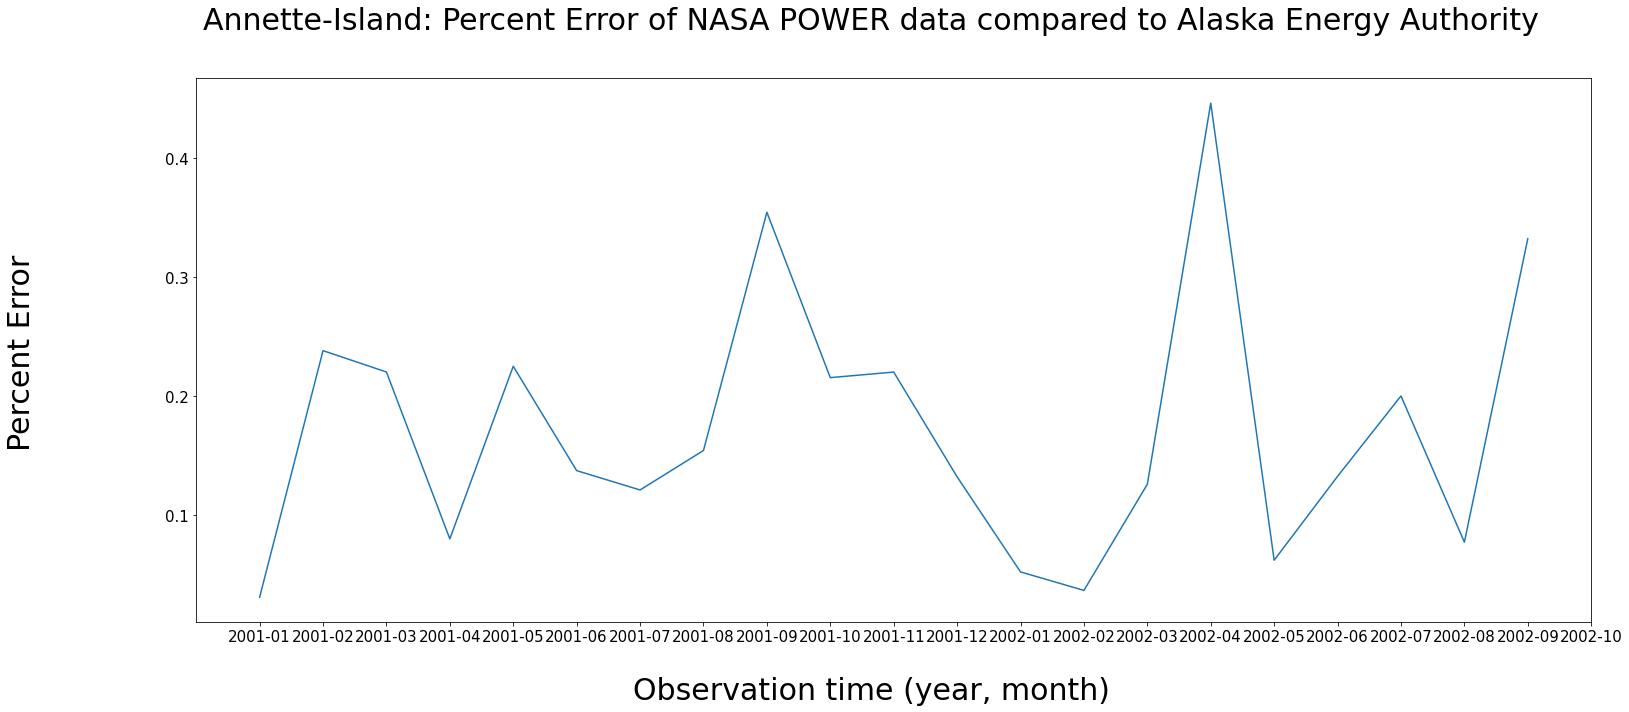

In [74]:
months = ["-01", "-02", "-03", "-04", "-05", "-06", "-07", "-08", "-09", "-10", "-11", "-12"]
year_months = []
for year in [2001, 2002]:
    for month in months:
        year_months.append(str(year) + month)
fig = plt.figure(figsize=(25, 10))
plt.plot(year_months, site_residual_dfs["Annette-Island"].percent_error)
fig.suptitle("Annette-Island: Percent Error of NASA POWER data compared to Alaska Energy Authority", fontsize=30)
fig.supxlabel("Observation time (year, month)", fontsize=30)
fig.supylabel("Percent Error", fontsize=30)
plt.show()

In [51]:
available_total = 0
available_sum = 0
for site in site_residual_dfs:
    temp_list = [point for point in site_residual_dfs[site].percent_error.values if np.isnan(point) == False and np.isinf(point) == False]
    available_total += len(temp_list)
    available_sum += sum(temp_list)
print(available_sum/available_total)

0.5565946392716778


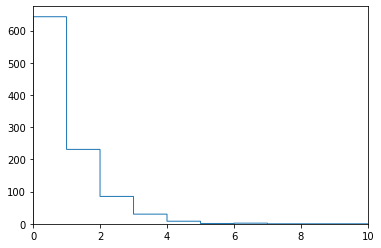

In [91]:
plt.hist(np.random.weibull(a=1, size=1000), bins=np.arange(1000), histtype="step")
plt.xlim(0,10)
plt.show()

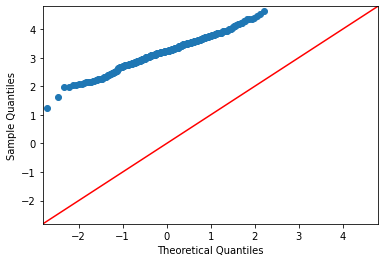

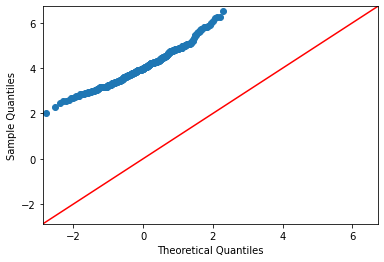

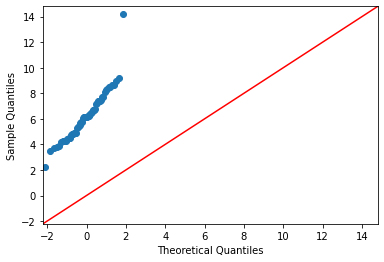

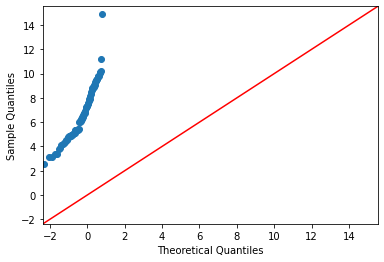

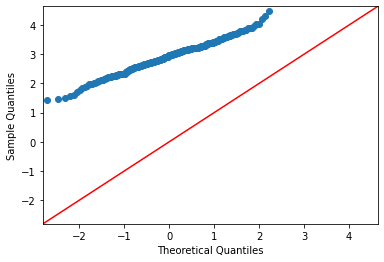

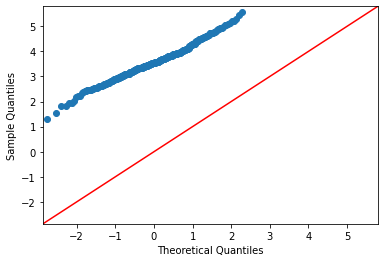

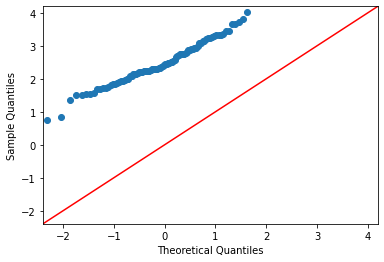

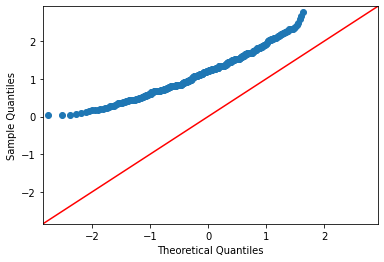

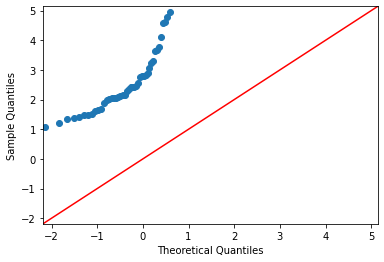

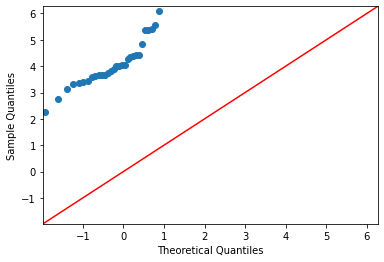

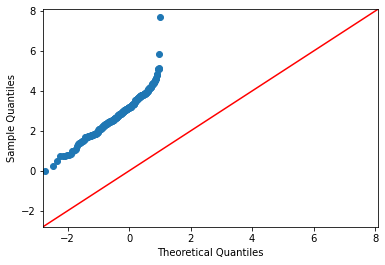

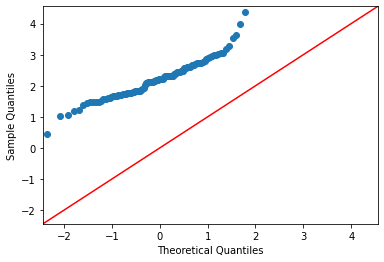

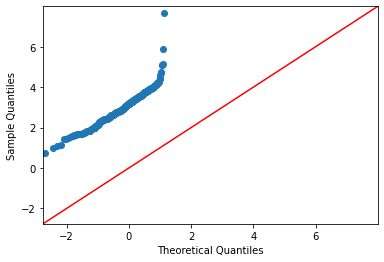

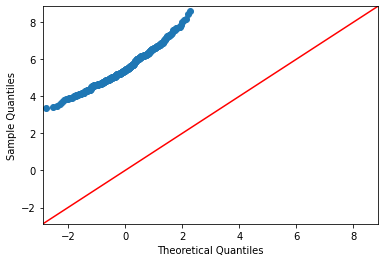

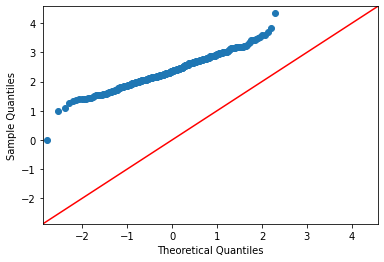

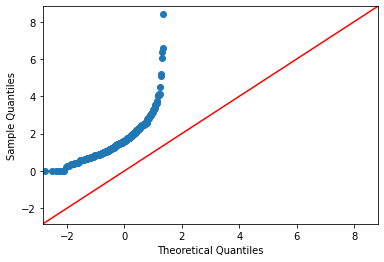

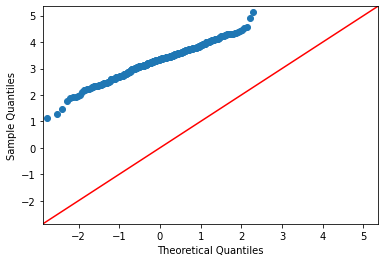

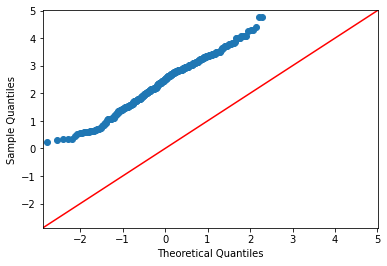

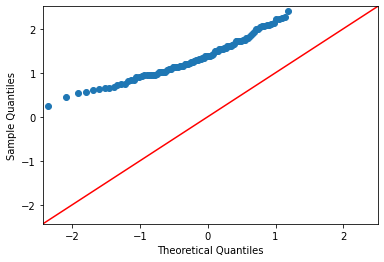

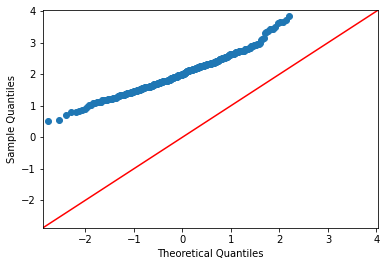

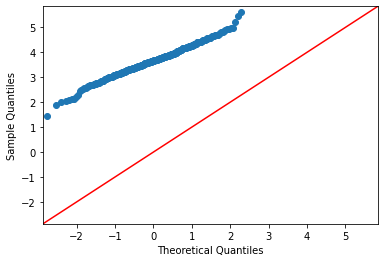

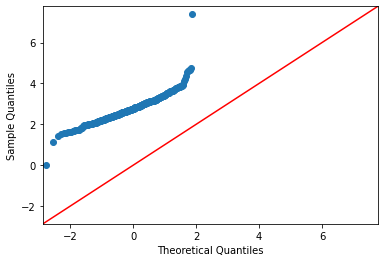

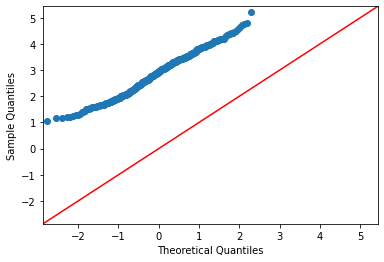

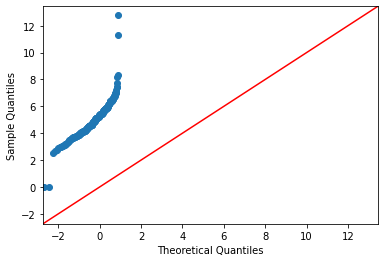

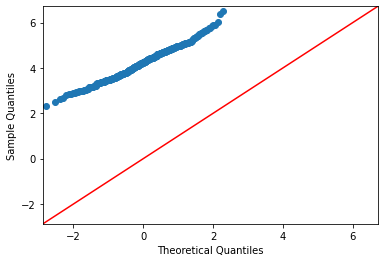

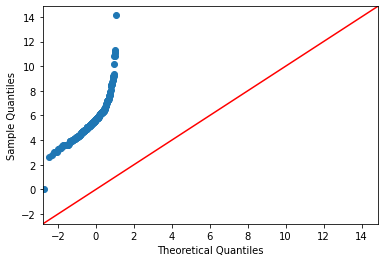

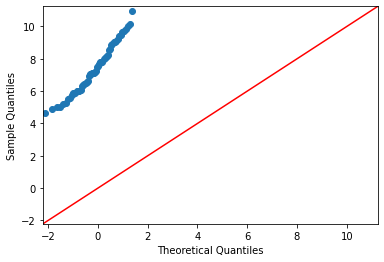

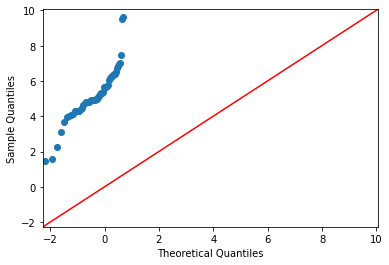

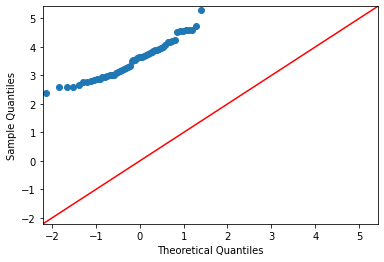

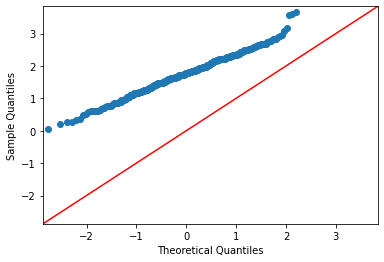

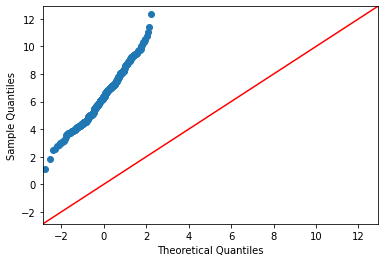

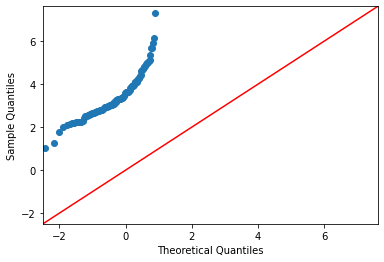

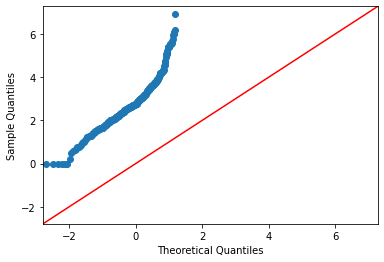

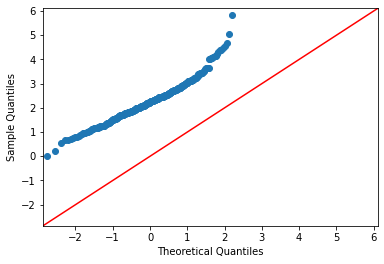

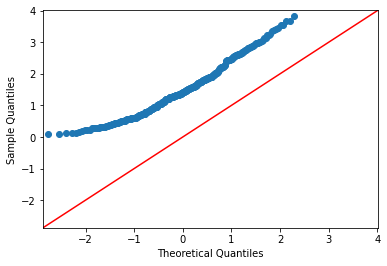

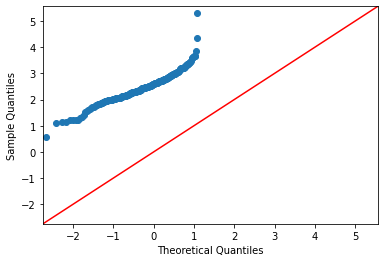

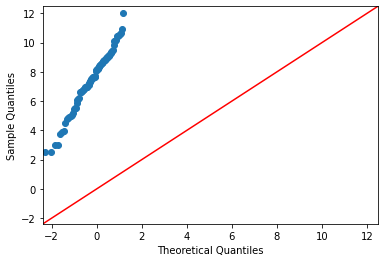

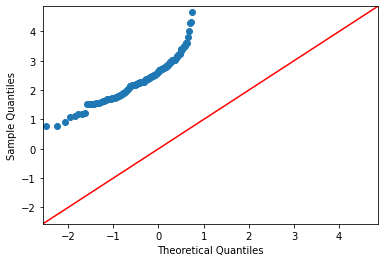

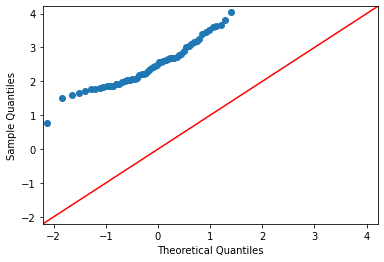

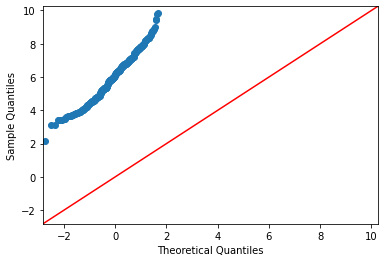

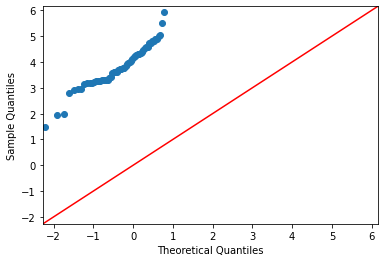

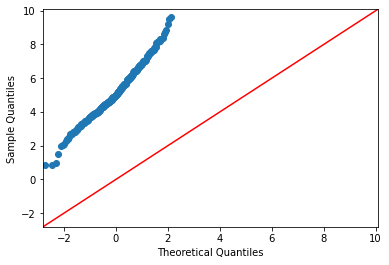

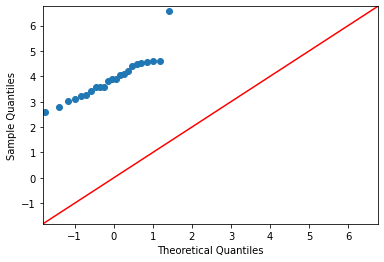

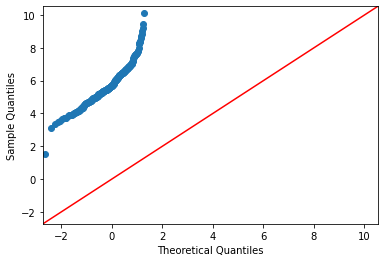

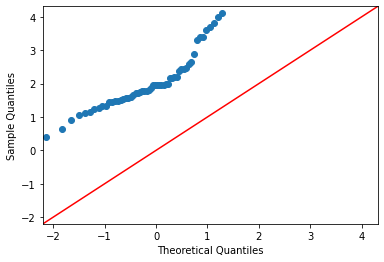

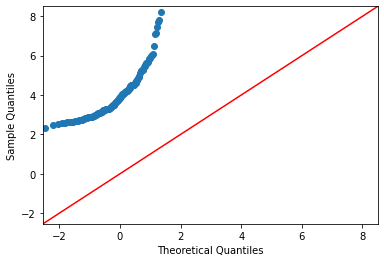

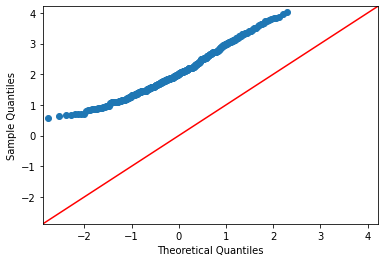

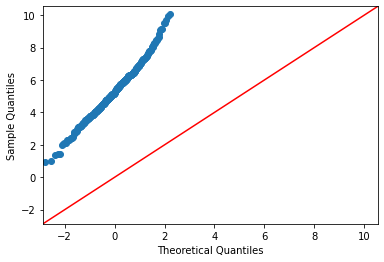

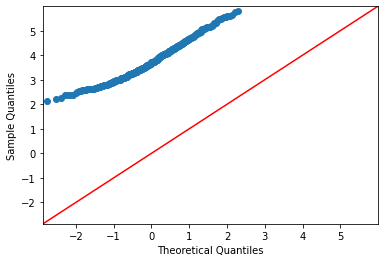

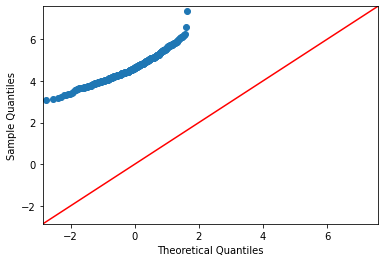

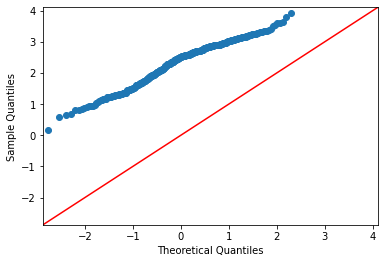

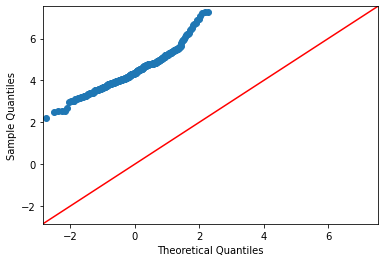

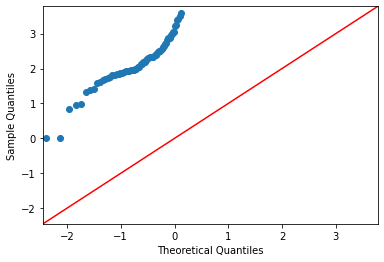

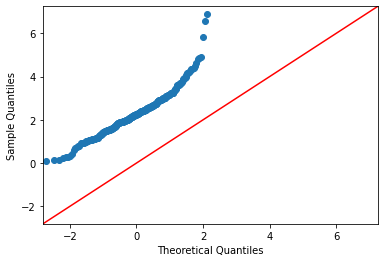

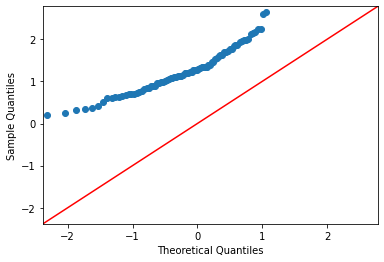

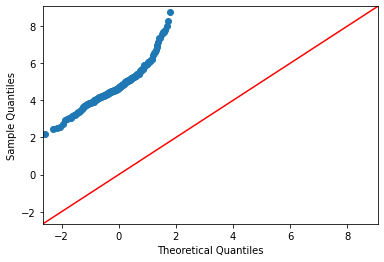

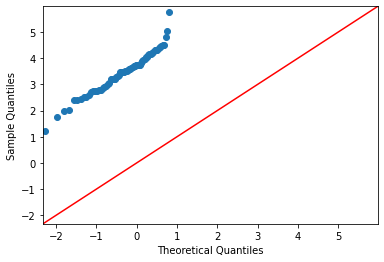

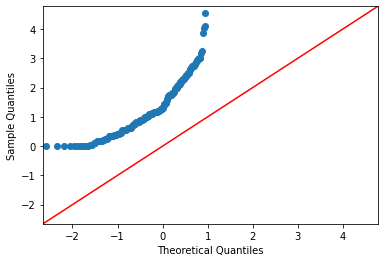

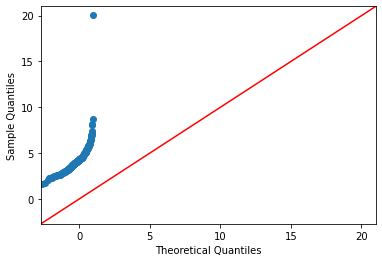

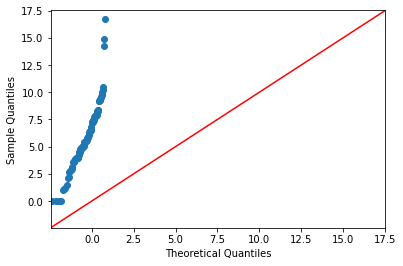

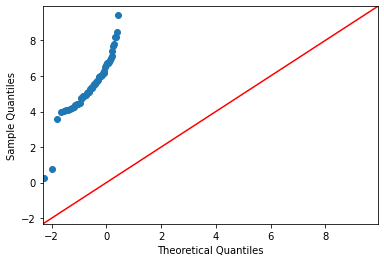

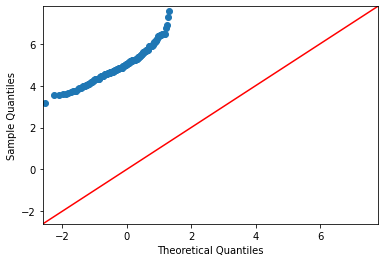

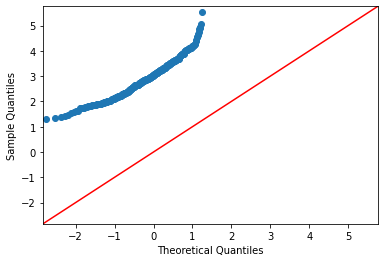

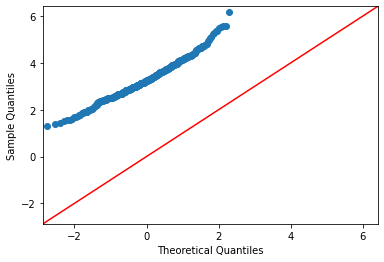

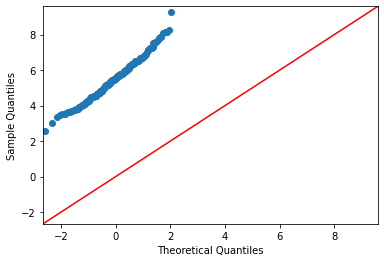

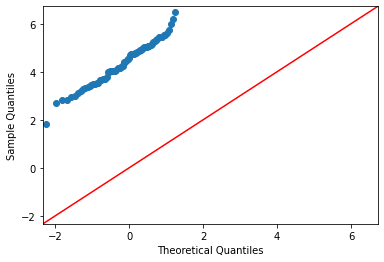

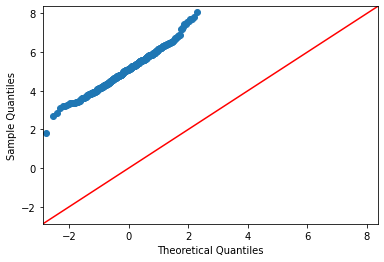

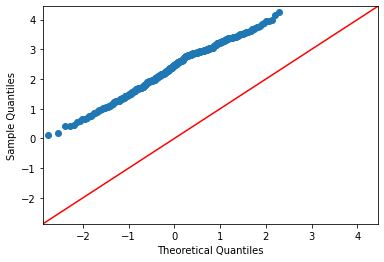

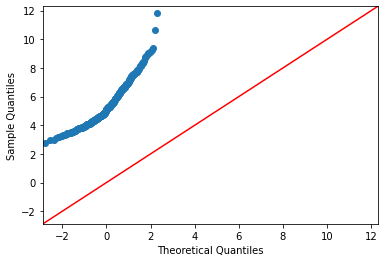

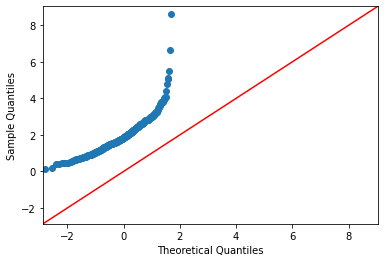

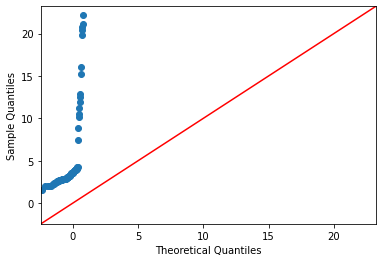

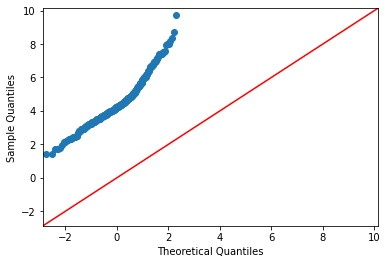

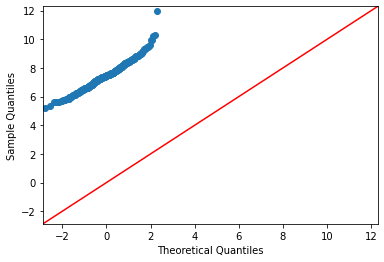

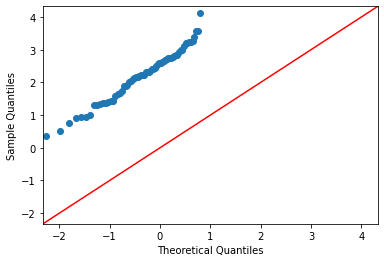

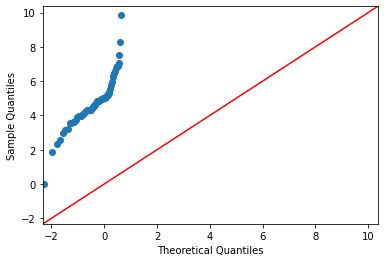

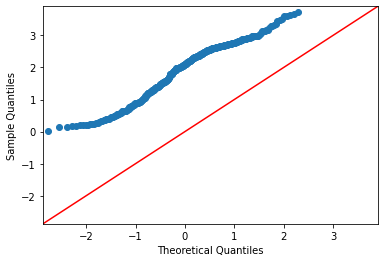

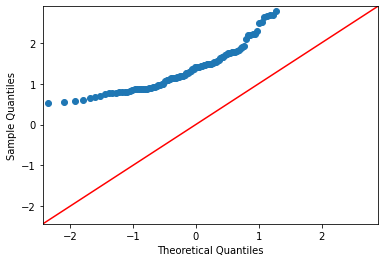

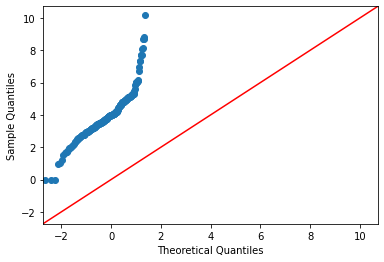

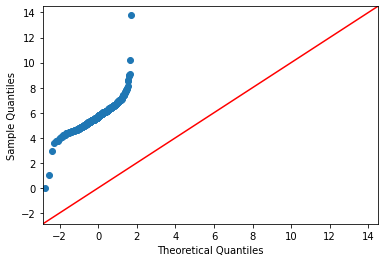

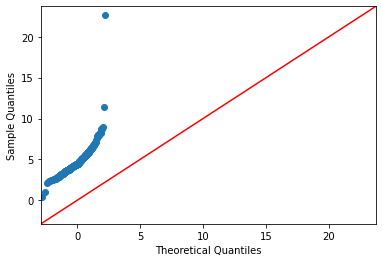

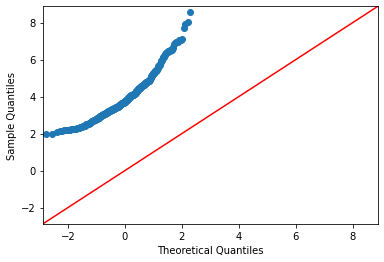

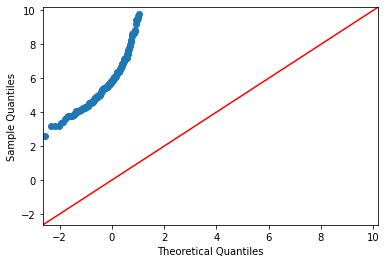

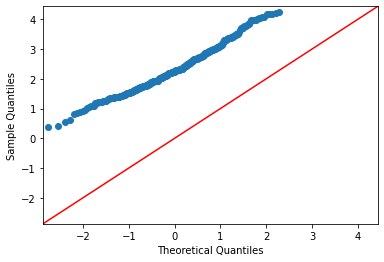

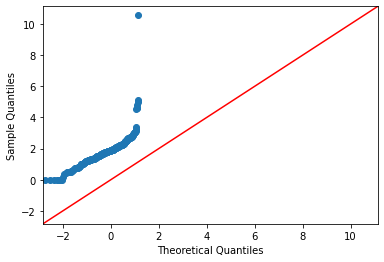

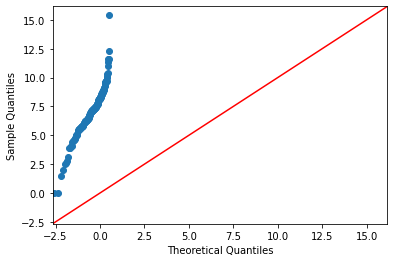

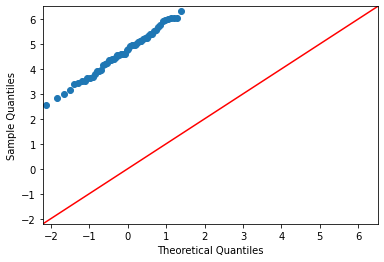

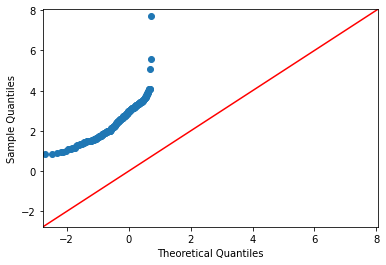

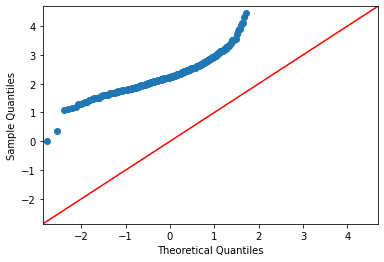

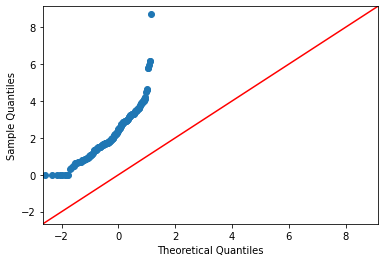

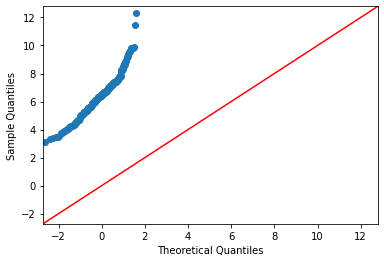

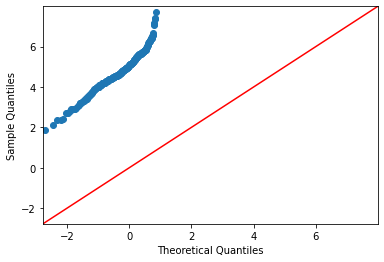

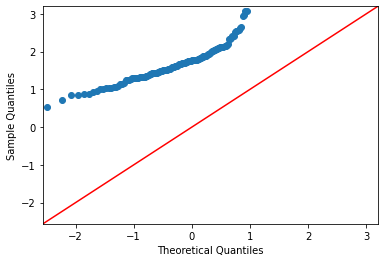

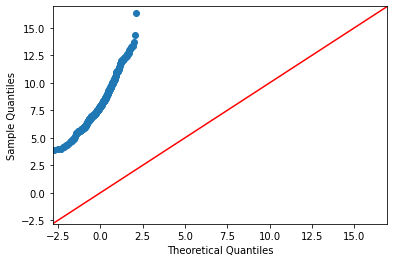

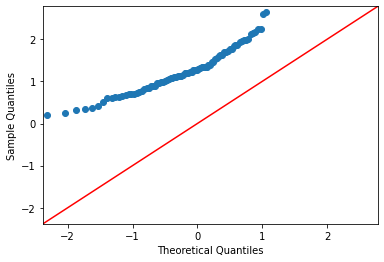

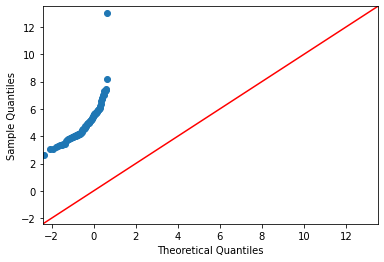

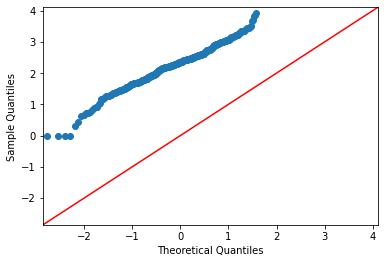

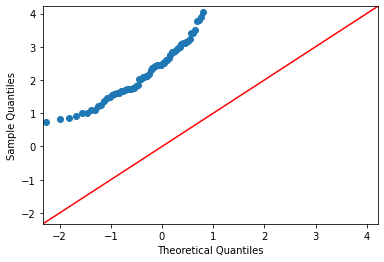

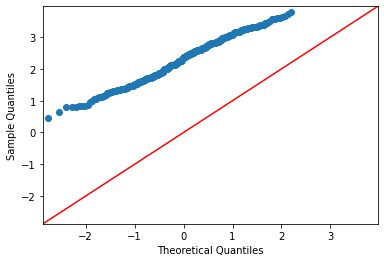

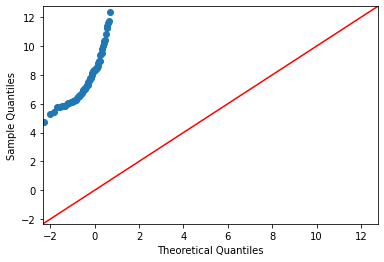

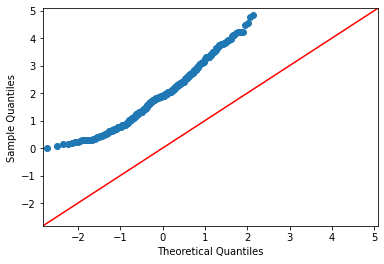

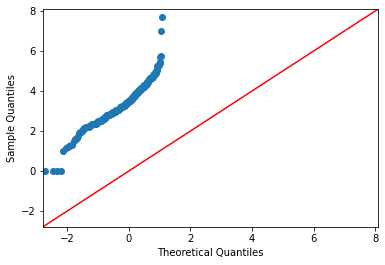

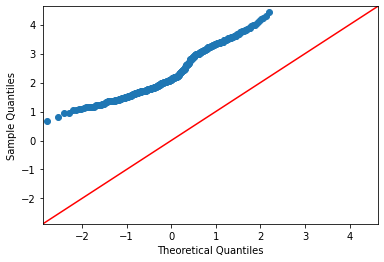

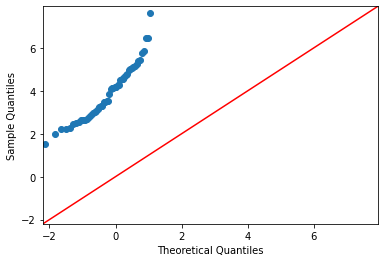

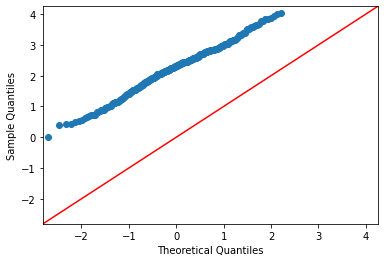

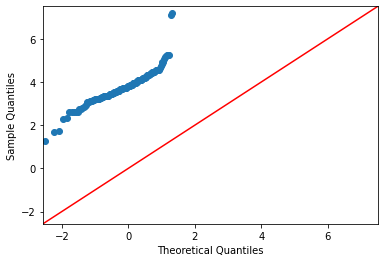

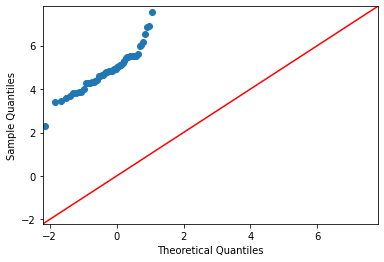

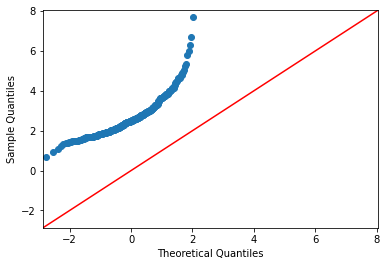

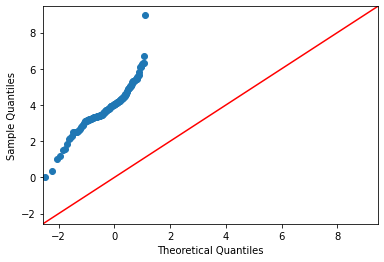

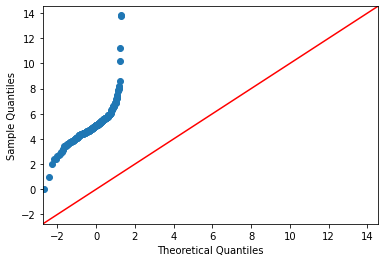

In [68]:
for site in aea_average_dfs:
    zs = []
    for point in nasa_raw_dfs.values():
        zs.append((point.nasa_speed - np.mean(aea_average_dfs[site].aea_wind_speed)) / np.std(aea_average_dfs[site].aea_wind_speed))
    # print("avg:",np.mean(aea_average_dfs[site].aea_wind_speed),"std:",np.std(aea_average_dfs[site].aea_wind_speed),"zmean",np.mean(zs))
    # plt.hist(aea_average_dfs[site].aea_wind_speed)
    # plt.show()
    sm.qqplot(aea_average_dfs[site].aea_wind_speed, line="45")
    plt.show()